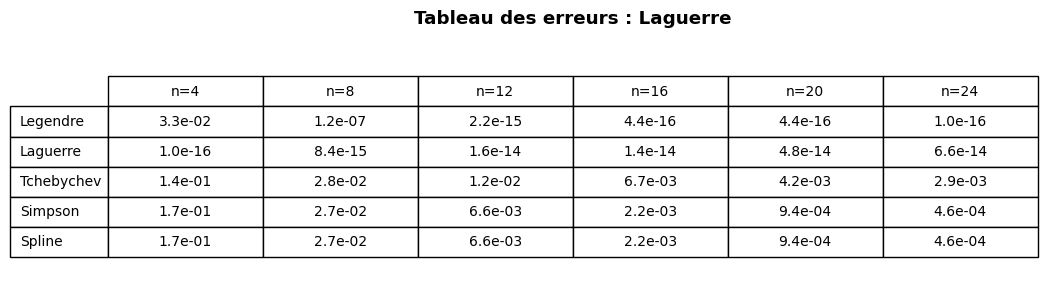

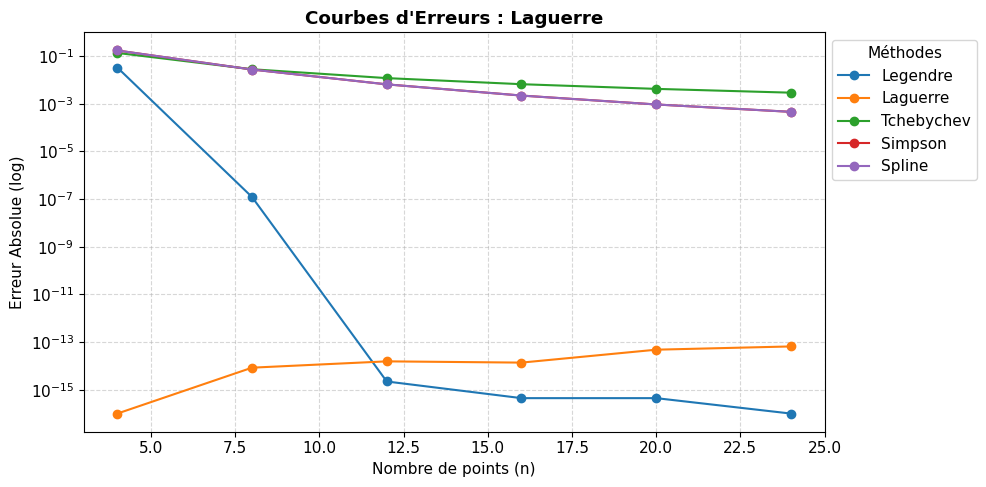

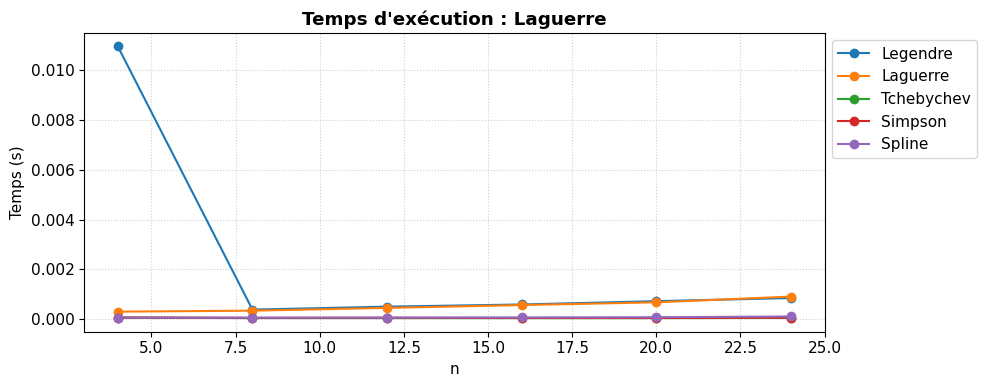

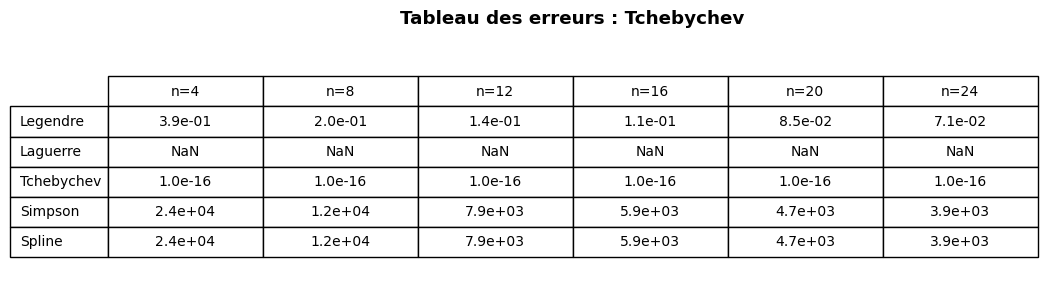

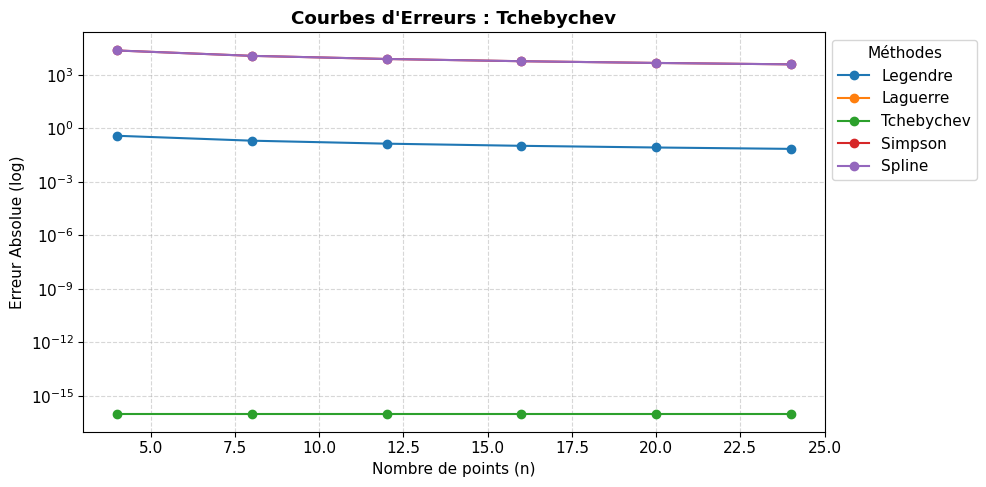

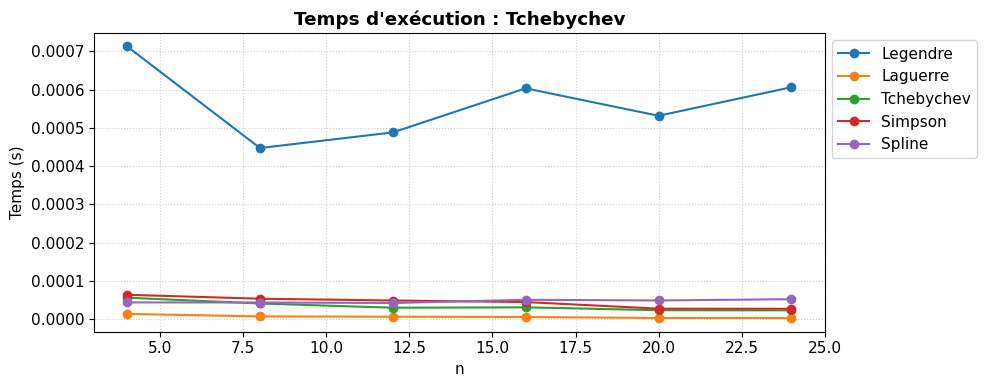

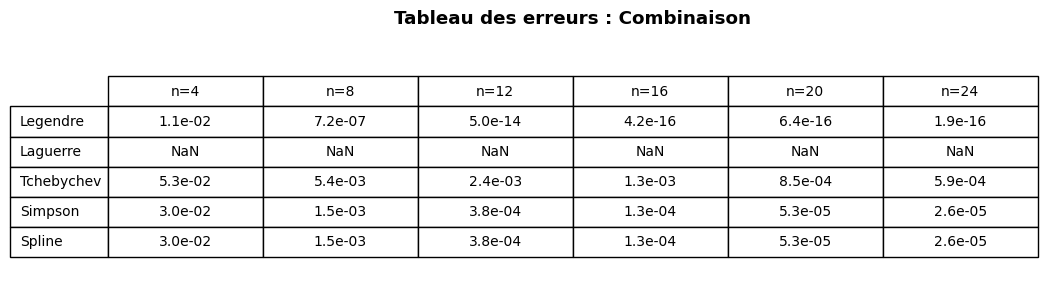

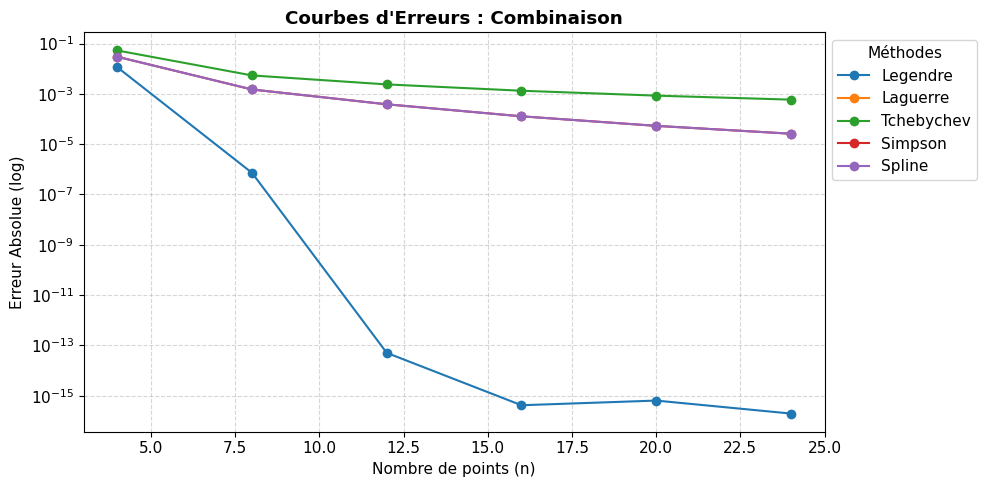

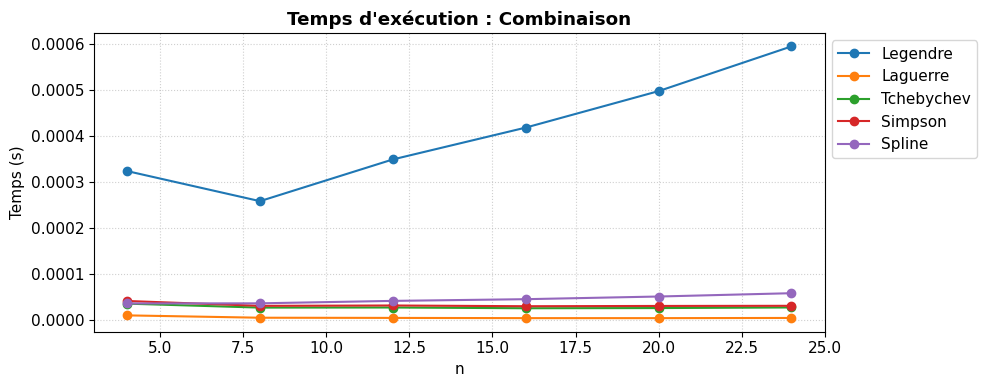

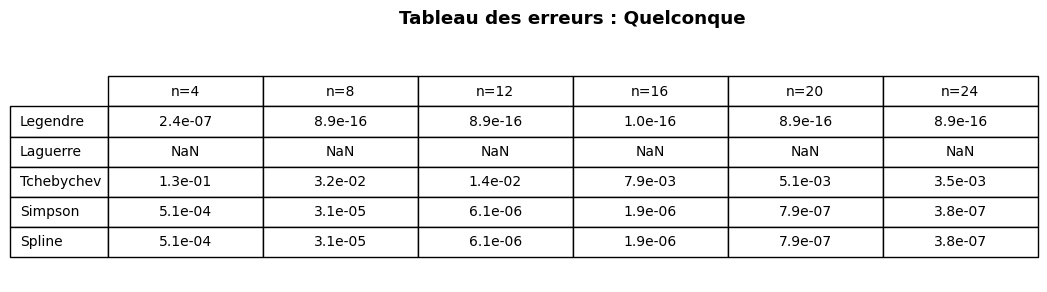

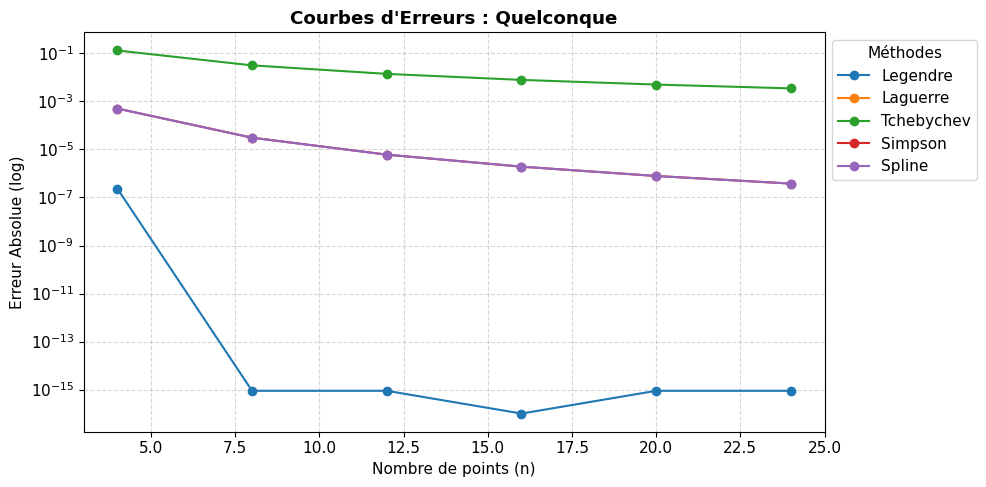

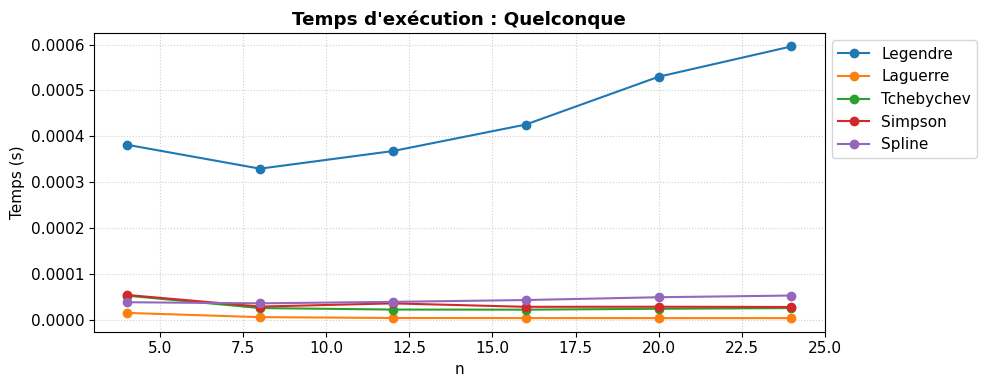

In [1]:
import numpy as np
import sympy as sp
import matplotlib.pyplot as plt
import time

# Configuration graphique
plt.rcParams["figure.figsize"] = (7,5)
plt.rcParams["font.size"] = 11

# ---------------- Méthodes d'intégration ----------------
def gauss_legendre(f, a, b, n):
    nodes, weights = np.polynomial.legendre.leggauss(n)
    x = 0.5*(b-a)*nodes + 0.5*(a+b)
    return 0.5*(b-a)*np.dot(weights, f(x))

def simpson(f, a, b, n):
    if n % 2 != 0:
        n += 1
    h = (b-a)/n
    x = np.linspace(a + 1e-10, b - 1e-10, n+1)
    y = f(x)
    return (h/3)*(y[0]+y[-1]+4*np.sum(y[1:-1:2])+2*np.sum(y[2:-1:2]))

def spline_quadratique(f, a, b, n):
    x = np.linspace(a + 1e-10, b - 1e-10, n+1)
    y = f(x)
    h = x[1]-x[0]
    z = np.zeros(n+1)
    # Amélioration légère : évite le crash si y[0] est infini, mais propage NaN
    if np.isfinite(y).all():
        z[0] = (y[1]-y[0])/h
        for i in range(n):
            z[i+1] = 2*(y[i+1]-y[i])/h - z[i]
        I = 0
        for i in range(n):
            a_i = (z[i+1]-z[i])/(2*h)
            b_i = z[i]
            c_i = y[i]
            I += a_i*h**3/3 + b_i*h**2/2 + c_i*h
        return I
    else:
        return np.nan

def gauss_laguerre(f, n):
    """
    Approxime l'intégrale :
    ∫₀^{+∞} e^{-x} f(x) dx
    selon la quadrature de Gauss–Laguerre
    """
    nodes, weights = np.polynomial.laguerre.laggauss(n)
    return np.dot(weights, f(nodes))

def gauss_tchebychev(f, a, b, n):
    k = np.arange(1, n+1)
    t = np.cos((2*k-1)*np.pi/(2*n))
    w = np.pi/n
    x = 0.5*(a+b) + 0.5*(b-a)*t
    dxdt = 0.5*(b-a)
    return w*np.sum(f(x)*dxdt*np.sqrt(1-t**2))

# ---------------- Fonction d'évaluation modifiée ----------------
def evaluer(calcul_integrale, n, I_exact):
    """
    calcul_integrale : fonction anonyme qui calcule l'intégrale pour un n donné
    """
    t0 = time.perf_counter()
    try:
        I_num = calcul_integrale(n)
    except Exception:
        I_num = np.nan

    t_exec = time.perf_counter() - t0

    if not np.isfinite(I_num):
        err = np.nan
    else:
        err = abs(I_exact - I_num)
        if err == 0:
            err = 1e-16

    if not np.isfinite(t_exec) or t_exec == 0:
        t_exec = 1e-16

    return err, t_exec

# ---------------- Définition des tests ----------------
x = sp.symbols("x")
fonctions = [
{"nom":"Laguerre",
 "famille":"laguerre",
 "g": x**2 + 1,        # partie sans le poids
 "a": 0,
 "b": 8               # troncature POUR les autres méthodes
},
# Tchebychev
{"nom":"Tchebychev", 
    "f": 1/sp.sqrt(1-x**2), 
    "a":-1, 
    "b":1},

# Combinaison
{"nom":"Combinaison", 
    "f": (x**2+1)*sp.exp(-x)*sp.cos(3*x), 
    "a":0, 
    "b":3},
    
# Fonction quelconque
{"nom":"Quelconque", 
    "f": sp.sin(x)+x**2, 
    "a":0, 
    "b":2}
]

methodes = {
    "Legendre": gauss_legendre,
    "Laguerre": gauss_laguerre,
    "Tchebychev": gauss_tchebychev,
    "Simpson": simpson,
    "Spline": spline_quadratique
}

n_vals = [4,8,12,16,20,24]

# ---------------- Boucle principale corrigée ----------------
for test in fonctions:

    erreurs = {m: [] for m in methodes}
    temps   = {m: [] for m in methodes}

    if test.get("famille") == "laguerre":
        g_sym = test["g"]
        g_num = sp.lambdify(x, g_sym, "numpy")

        a, b = test["a"], test["b"]
        f_tronc_sym = g_sym * sp.exp(-x)
        f_tronc_num = sp.lambdify(x, f_tronc_sym, "numpy")
        
        # --- ON CALCULE LES DEUX RÉFÉRENCES ICI ---
        I_exact_inf = float(sp.integrate(f_tronc_sym, (x, 0, sp.oo)))
        I_exact_tronq = float(sp.integrate(f_tronc_sym, (x, a, b)))
        # ------------------------------------------

    else:
        f_sym = test["f"]
        a, b = test["a"], test["b"]
        f_num = sp.lambdify(x, f_sym, "numpy")
        I_exact = float(sp.integrate(f_sym, (x, a, b)))

    for n in n_vals:
        for nom, meth in methodes.items():
            if test.get("famille") == "laguerre":
                if nom == "Laguerre":
                    # Laguerre vise l'intégrale complète [0, inf[
                    calc = lambda n, g=g_num: gauss_laguerre(g, n)
                    e, t = evaluer(calc, n, I_exact_inf)
                else:
                    # Les autres ne visent que la partie tronquée [a, b]
                    calc = lambda n, f=f_tronc_num, a=a, b=b, m=meth: m(f, a, b, n)
                    e, t = evaluer(calc, n, I_exact_tronq)
            else:
                # Cas standard (Tchebychev, Quelconque, etc.)
                calc = lambda n, f=f_num, a=a, b=b, m=meth: m(f, a, b, n)
                e, t = evaluer(calc, n, I_exact)
            
            erreurs[nom].append(e)
            temps[nom].append(t)

            
             
   # =======================================================
    # NOUVEAU BLOC D'AFFICHAGE : TABLEAU PUIS GRAPHIQUE
    # =======================================================
    
    # --- 1. PRÉPARATION DES DONNÉES ---
    cell_text = []
    rows = list(methodes.keys())
    cols = [f"n={n}" for n in n_vals]

    for m in methodes:
        row_data = []
        for val in erreurs[m]:
            if np.isnan(val):
                row_data.append("NaN")
            else:
                row_data.append(f"{val:.1e}")
        cell_text.append(row_data)

    # --- 2. AFFICHAGE DU TABLEAU SEUL ---
    fig_tab, ax_tab = plt.subplots(figsize=(10, 3)) # Figure courte pour le tableau
    ax_tab.axis('off') # On cache les axes
    ax_tab.set_title(f"Tableau des erreurs : {test['nom']}", fontweight='bold', pad=20)

    the_table = ax_tab.table(cellText=cell_text,
                             rowLabels=rows,
                             colLabels=cols,
                             loc='center',
                             cellLoc='center')
    the_table.auto_set_font_size(False)
    the_table.set_fontsize(10)
    the_table.scale(1.2, 1.8) # On agrandit un peu les cellules pour la lisibilité
    plt.show()

    # --- 3. AFFICHAGE DU GRAPHIQUE D'ERREUR ---
    fig_err, ax_err = plt.subplots(figsize=(10, 5))
    
    for m in erreurs:
        data = np.array(erreurs[m], dtype=float)
        ax_err.plot(n_vals, data, marker='o', label=m, linewidth=1.5)
        
    ax_err.set_yscale("log")
    ax_err.set_title(f"Courbes d'Erreurs : {test['nom']}", fontweight='bold')
    ax_err.set_xlabel("Nombre de points (n)")
    ax_err.set_ylabel("Erreur Absolue (log)")
    ax_err.grid(True, which="both", linestyle="--", alpha=0.5)

    # LÉGENDE À L'EXTÉRIEUR (à droite) pour ne pas couvrir les courbes
    ax_err.legend(loc='upper left', bbox_to_anchor=(1, 1), title="Méthodes")
    
    plt.tight_layout() # Ajuste automatiquement pour que rien ne dépasse
    plt.show()

    # --- 4. AFFICHAGE DU GRAPHIQUE DE TEMPS ---
    plt.figure(figsize=(10, 4))
    for m in temps:
        plt.plot(n_vals, temps[m], marker='o', label=m)
    
    plt.title(f"Temps d'exécution : {test['nom']}", fontweight='bold')
    plt.xlabel("n")
    plt.ylabel("Temps (s)")
    plt.grid(True, linestyle=":", alpha=0.6)
    
    # Légende à l'extérieur ici aussi par cohérence
    plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
    
    plt.tight_layout()
    plt.show()
    # =======================================================